https://github.com/keunwoochoi/keras_cropping_layer/blob/master/cnn_cropping.py

### Import libraries and modify notebook settings

In [92]:
# Import libraries
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from pysndfx import AudioEffectsChain
from IPython.display import Audio, display

#from models.randomcrop import RandomCropping1D
from models.dualplotcallback import DualPlotCallback

from utils.bedtime import computer_sleep
from utils.format_bytes_size import FormatBytesSize
# Modify notebook settings
%matplotlib inline

In [93]:
from keras.utils import HDF5Matrix
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Activation

from keras.layers import Dense, Flatten
#from keras.layers import InputSpec, Layer
#from keras.utils import conv_utils


### Create paths to data folders and files

In [3]:
# Create a variable for the project root directory
proj_root = os.path.join(os.pardir)

# Save path to the raw metadata file
# "UrbanSound8K.csv"
metadata_file = os.path.join(proj_root,
                             "data",
                             "raw",
                             "UrbanSound8K",
                             "metadata",
                             "UrbanSound8K.csv")

# Save path to the raw audio files
raw_audio_path = os.path.join(proj_root,
                             "data",
                             "raw",
                             "UrbanSound8K",
                             "audio")

# Save path to the raw audio files
fold1_path = os.path.join(raw_audio_path,
                          "fold1")


# Save the path to the folder that will contain 
# the interim data sets for modeling:
# /data/interim
interim_data_dir = os.path.join(proj_root,
                                "data",
                                "interim")


# Save the path to the folder that will contain 
# the interim trash data sets
# /data/interim
interim_trash_dir = os.path.join(interim_data_dir,
                                "trash")

# Save path to the folder for the
# spectrogram arrays that we will generate
spectrogram_arrays_path = os.path.join(interim_data_dir,
                                       "spectrogram_arrays")


In [4]:
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(proj_root, "src")
sys.path.append(src_dir)

# ...

In [5]:
new_file_name = 'metadata_test.csv'
new_file_path = os.path.join(interim_data_dir,
                             new_file_name)
df_test = pd.read_csv(new_file_path, index_col=0)

test_len = len(df_test)

In [6]:
new_file_name = 'metadata_train.csv'
new_file_path = os.path.join(interim_data_dir,
                             new_file_name)
df_train = pd.read_csv(new_file_path, index_col=0)

train_len = len(df_train)

## Process audio files

In [7]:
global_sr = 22050

In [8]:
seconds = 4

chunk_tuple = (1, (global_sr * seconds), 1)

X_test_shape_tuple = (test_len, (global_sr * seconds), 1)
X_train_shape_tuple = (train_len, (global_sr * seconds), 1)

y_test_shape_tuple = (test_len, 1)
y_train_shape_tuple = (train_len, 1)

print('chunk_tuple:\t\t', chunk_tuple)
print('X_test_shape_tuple:\t', X_test_shape_tuple)
print('X_train_shape_tuple:\t', X_train_shape_tuple)
print('y_test_shape_tuple:\t', y_test_shape_tuple)
print('y_train_shape_tuple:\t', y_train_shape_tuple)

chunk_tuple:		 (1, 88200, 1)
X_test_shape_tuple:	 (1374, 88200, 1)
X_train_shape_tuple:	 (5740, 88200, 1)
y_test_shape_tuple:	 (1374, 1)
y_train_shape_tuple:	 (5740, 1)


In [51]:
hdf5_file_name = 'sample-level.hdf5'
hdf5_path = os.path.join(interim_trash_dir, hdf5_file_name)
hdf5_path

'../data/interim/trash/sample-level.hdf5'

In [52]:
with h5py.File(hdf5_path, 'w') as f:
    f.create_dataset("X_test_dset", 
                     shape=X_test_shape_tuple, 
                     dtype='float32',
                     data=np.zeros(X_test_shape_tuple, dtype='float32'),
                     chunks=chunk_tuple,
                     compression="gzip")
    
    f.create_dataset("X_train_dset", 
                     shape=X_train_shape_tuple, 
                     dtype='float32',
                     data=np.zeros(X_train_shape_tuple, dtype='float32'),
                     chunks=chunk_tuple,
                     compression="gzip")
            
    f.create_dataset("y_test_dset", 
                     shape=y_test_shape_tuple, 
                     dtype='int8',
                     data=np.zeros(y_test_shape_tuple, dtype='int8'),
                     compression="gzip")
            
    f.create_dataset("y_train_dset", 
                     shape=y_train_shape_tuple, 
                     dtype='int8',
                     data=np.zeros(y_train_shape_tuple, dtype='int8'),
                     compression="gzip")
    

In [58]:
#Populate X_train_dset and y_train_dset in hdf5_path

count = 0

for index, (_, row) in enumerate(df_train.iterrows()):
    
    sys.stdout.write("\rCount:\t {:,}  of  ".format(count) + \
                     "{:,}  ".format(y_train_shape_tuple[0]) + \
                     "({:.1f}%) \t\tSpace: ".format(100 * (count / y_train_shape_tuple[0])) + \
                     FormatBytesSize(os.path.getsize(hdf5_path)))        
    sys.stdout.flush()
    sys.stdout.write('\r')
    
    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                             fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
    
    # Load the .wav audio_file
    aud_array, _ = librosa.load(audio_path, sr=global_sr)

    classID = row['classID']
    
    # Write to the hdf5 file
    with h5py.File(hdf5_path, "r+") as f:
        # X_train
        dset = f['X_train_dset']    

        # limit tensor height to 173 (there were a few tensors with 174)
        dset[count,:,] = aud_array[np.newaxis, :88200, np.newaxis]
        
        # y_train
        dset = f['y_train_dset']    
        dset[count,:] = row['classID']

    count += 1   
    
    
sys.stdout.write("\rCount:\t {:,}  of  ".format(count) + \
                 "{:,}  ".format(y_train_shape_tuple[0]) + \
                 "({:.1f}%) \t\tSpace: ".format(100 * (count / y_train_shape_tuple[0])) + \
                 FormatBytesSize(os.path.getsize(hdf5_path)))        
sys.stdout.flush()
sys.stdout.write('\r')

In [61]:
#Populate X_test_dset and y_test_dset in hdf5_path

count = 0

for index, (_, row) in enumerate(df_test.iterrows()):

    sys.stdout.write("\rCount:\t {:,}  of  ".format(count) + \
                     "{:,}  ".format(y_test_shape_tuple[0]) + \
                     "({:.1f}%) \t\tSpace: ".format(100 * (count / y_test_shape_tuple[0])) + \
                     FormatBytesSize(os.path.getsize(hdf5_path)))
    sys.stdout.flush()
    sys.stdout.write('\r')
    
    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                             fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
    
    # Load the .wav audio_file
    aud_array, _ = librosa.load(audio_path, sr=global_sr)

    classID = row['classID']
    
    # Write to the hdf5 file
    with h5py.File(hdf5_path, "r+") as f:
        # X_test
        dset = f['X_test_dset']    

        # limit tensor height to 173 (there were a few tensors with 174)
        dset[count,:,] = aud_array[np.newaxis, :88200, np.newaxis]
        
        # y_test
        dset = f['y_test_dset']    
        dset[count,:] = row['classID']

    count += 1   

sys.stdout.write("\rCount:\t {:,}  of  ".format(count) + \
                 "{:,}  ".format(y_test_shape_tuple[0]) + \
                 "({:.1f}%) \t\tSpace: ".format(100 * (count / y_test_shape_tuple[0])) + \
                 FormatBytesSize(os.path.getsize(hdf5_path)))
sys.stdout.flush()
sys.stdout.write('\r')    

# Create objects for X_train, y_train, X_test, & y_test

In [62]:
X_train = HDF5Matrix(hdf5_path, 
                     'X_train_dset')

y_train = HDF5Matrix(hdf5_path, 
                     'y_train_dset')

X_test = HDF5Matrix(hdf5_path, 
                     'X_test_dset')

y_test = HDF5Matrix(hdf5_path, 
                     'y_test_dset')

In [63]:
# 6. Preprocess class labels
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

In [64]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(5740, 88200, 1)
(1374, 88200, 1)
(5740, 1)
(1374, 1)
(5740, 10)
(1374, 10)


# Model

In [65]:
int(global_sr * 1)

22050

In [79]:
'''ResNeXt models for Keras.
# Reference
- [Aggregated Residual Transformations for Deep Neural Networks](https://arxiv.org/pdf/1611.05431.pdf))
'''
#from __future__ import print_function
#from __future__ import absolute_import
#from __future__ import division

import warnings

from keras.models import Model
from keras.layers.core import Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalAveragePooling1D, GlobalMaxPool1D, MaxPool1D

from keras.layers import Input
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
import keras.backend as K

###UNDO EDIT###
from models.randomcrop import RandomCropping1D
###UNDO EDIT###

def ResNext1D(input_shape=None, depth=29, cardinality=8, width=64, weight_decay=5e-4,
              include_top=True, weights=None, input_tensor=None,
              pooling=None, classes=10, cropping=22050):
    """Instantiate the ResNeXt architecture. Note that ,
        when using TensorFlow for best performance you should set
        `image_data_format="channels_last"` in your Keras config
        at ~/.keras/keras.json.
        The model are compatible with both
        TensorFlow and Theano. The dimension ordering
        convention used by the model is the one
        specified in your Keras config file.
        # Arguments
            depth: number or layers in the ResNeXt model. Can be an
                integer or a list of integers.
            cardinality: the size of the set of transformations
            width: multiplier to the ResNeXt width (number of filters)
            weight_decay: weight decay (l2 norm)
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: `None` (random initialization)
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False 
        #                (otherwise the input shape
        #                has to be `(32, 32, 3)` (with `tf` dim ordering)
        #                or `(3, 32, 32)` (with `th` dim ordering).
        #                It should have exactly 3 inputs channels,
        #                and width and height should be no smaller than 8.
        #                E.g. `(200, 200, 3)` would be one valid value.
            pooling: Optional pooling mode for feature extraction
                when `include_top` is `False`.
                - `None` means that the output of the model will be
                    the 4D tensor output of the
                    last convolutional layer.
                - `avg` means that global average pooling
                    will be applied to the output of the
                    last convolutional layer, and thus
                    the output of the model will be a 2D tensor.
                - `max` means that global max pooling will
                    be applied.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
        # Returns
            A Keras model instance.
        """

    if type(depth) == int:
        if (depth - 2) % 9 != 0:
            raise ValueError('Depth of the network must be such that (depth - 2)'
                             'should be divisible by 9.')


#    if input_tensor is None:
#        img_input = Input(shape=input_shape)
#    else:
#        if not K.is_keras_tensor(input_tensor):
#            img_input = Input(tensor=input_tensor, shape=input_shape)
#        else:
#            img_input = input_tensor


    # RENAME img_input
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    
    x = __create_res_next(classes, img_input, include_top, depth, cardinality,
                          width, weight_decay, pooling, cropping)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnext')

    return model


def __initial_conv_block(input, weight_decay=5e-4, cropping=22050):
    ''' Adds an initial convolution block, with batch normalization and relu activation
    Args:
        input: input tensor
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
#EDIT    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

#    x = Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_initializer='he_normal',
#               kernel_regularizer=l2(weight_decay))(input)

###UNDO EDIT###
#    x = Conv1D(64, 3, padding='same', use_bias=False, kernel_initializer='he_normal',
#               kernel_regularizer=l2(weight_decay))(input)

    
###UNDO EDIT###
#    x = Conv1D(64, 3, padding='same', use_bias=False, kernel_initializer='he_normal',
#               kernel_regularizer=l2(weight_decay))(input)

#    model.add(Activation(None, input_shape=(88200, 1)))
    x = RandomCropping1D(cropping)(input)
###UNDO EDIT###    


###UNDO EDIT###
#    x = BatchNormalization(axis=channel_axis)(x)
#    x = LeakyReLU()(x)
###UNDO EDIT###  

    return x


def __grouped_convolution_block(input, grouped_channels, cardinality, strides, weight_decay=5e-4):
    ''' Adds a grouped convolution block. It is an equivalent block from the paper
    Args:
        input: input tensor
        grouped_channels: grouped number of filters
        cardinality: cardinality factor describing the number of groups
        strides: performs strided convolution for downscaling if > 1
        weight_decay: weight decay term
    Returns: a keras tensor
    '''
    init = input
# EDIT    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    group_list = []

    if cardinality == 1:
        # with cardinality 1, it is a standard convolution
        
        x = Conv1D(grouped_channels, 3, padding='same', use_bias=False, strides=strides,
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)

        x = BatchNormalization(axis=channel_axis)(x)
        x = LeakyReLU()(x)
        return x

    for c in range(cardinality):
#        x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels]
#                   if K.image_data_format() == 'channels_last' else
#                   lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :, :])(input)

        x = Lambda(lambda z: z[:, :, c * grouped_channels:(c + 1) * grouped_channels]
                   if K.image_data_format() == 'channels_last' else
                   lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :])(input)

#        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
#                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

# INDENT
        x = Conv1D(grouped_channels, 3, padding='same', use_bias=False, strides=strides, 
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

        group_list.append(x)

    group_merge = concatenate(group_list, axis=channel_axis)
    x = BatchNormalization(axis=channel_axis)(group_merge)
    x = LeakyReLU()(x)

    return x


def __bottleneck_block(input, filters=64, cardinality=8, strides=1, weight_decay=5e-4):
    ''' Adds a bottleneck block
    Args:
        input: input tensor
        filters: number of output filters
        cardinality: cardinality factor described number of
            grouped convolutions
        strides: performs strided convolution for downsampling if > 1
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
    init = input

    grouped_channels = int(filters / cardinality)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 16 * k, else create convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init._keras_shape[1] != 2 * filters:

            init = Conv1D(filters * 2, 1, padding='same', strides=strides,
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)

            init = BatchNormalization(axis=channel_axis)(init)
    else:
        if init._keras_shape[-1] != 2 * filters:

            init = Conv1D(filters * 2, 1, padding='same', strides=strides,
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)

            init = BatchNormalization(axis=channel_axis)(init)

#    x = Conv2D(filters, (1, 1), padding='same', use_bias=False,
#               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)

#INDENT
    x = Conv1D(filters, 1, padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(input)

    x = BatchNormalization(axis=channel_axis)(x)
    x = LeakyReLU()(x)

    x = __grouped_convolution_block(x, grouped_channels, cardinality, strides, weight_decay)

    x = Conv1D(filters * 2, 1, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

    x = BatchNormalization(axis=channel_axis)(x)

    x = add([init, x])
    x = LeakyReLU()(x)

    return x


def __create_res_next(nb_classes, img_input, include_top, depth=29, cardinality=8, width=4,
                      weight_decay=5e-4, pooling=None, cropping=22050):    
    ''' Creates a ResNeXt model with specified parameters
    Args:
        nb_classes: Number of output classes
        img_input: Input tensor or layer
        include_top: Flag to include the last dense layer
        depth: Depth of the network. Can be an positive integer or a list
               Compute N = (n - 2) / 9.
               For a depth of 56, n = 56, N = (56 - 2) / 9 = 6
               For a depth of 101, n = 101, N = (101 - 2) / 9 = 11
        cardinality: the size of the set of transformations.
               Increasing cardinality improves classification accuracy,
        width: Width of the network.
        weight_decay: weight_decay (l2 norm)
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
    Returns: a Keras Model
    '''

    if type(depth) is list or type(depth) is tuple:
        # If a list is provided, defer to user how many blocks are present
        N = list(depth)
    else:
        # Otherwise, default to 3 blocks each of default number of group convolution blocks
        N = [(depth - 2) // 9 for _ in range(3)]

    filters = cardinality * width
    filters_list = []

    for i in range(len(N)):
        filters_list.append(filters)
        
###UNDO EDIT###        
#        filters *= 2  # double the size of the filters
###UNDO EDIT###
        filters *= 2  # double the size of the filters
        
    x = __initial_conv_block(img_input, weight_decay, cropping)

    # block 1 (no pooling)
    for i in range(N[0]):
        x = __bottleneck_block(x, filters_list[0], cardinality, strides=1, weight_decay=weight_decay)

    N = N[1:]  # remove the first block from block definition list
    filters_list = filters_list[1:]  # remove the first filter from the filter list

    # block 2 to N
    for block_idx, n_i in enumerate(N):
        for i in range(n_i):
            if i == 0:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=2,
                                       weight_decay=weight_decay)
            else:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=1,
                                       weight_decay=weight_decay)
                
    if include_top:
        x = GlobalAveragePooling1D()(x)
        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  kernel_initializer='he_normal', activation='softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    return x


# ... Have ResNext1D infer classes=Y_train.shape[1]

In [80]:
ResNext1D?

In [100]:
chunk_tuple[1:]

(88200, 1)

In [83]:
inpu = X_train.shape[1:] # chunk_tuple[1:]
dept = 11
card = 1 # 3
widt = 32 # 64
weig = 5e-4
clas = Y_train.shape[1]
crop = int(global_sr * 1)

model_resnext1d = ResNext1D(input_shape=inpu, 
                            depth=dept,
                            cardinality=card,
                            width=widt,
                            weight_decay=weig, 
                            classes=clas, cropping=crop)   

model_resnext1d.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model_resnext1d.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 88200, 1)      0                                            
____________________________________________________________________________________________________
random_cropping1d_5 (RandomCropp (None, 22050, 1)      0           input_7[0][0]                    
____________________________________________________________________________________________________
conv1d_50 (Conv1D)               (None, 22050, 32)     32          random_cropping1d_5[0][0]        
____________________________________________________________________________________________________
batch_normalization_50 (BatchNor (None, 22050, 32)     128         conv1d_50[0][0]                  
___________________________________________________________________________________________

In [89]:
help(model_resnext1d.fit)

Help on method fit in module keras.engine.training:

fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, **kwargs) method of keras.engine.training.Model instance
    Trains the model for a fixed number of epochs (iterations on a dataset).
    
    # Arguments
        x: Numpy array of training data,
            or list of Numpy arrays if the model has multiple inputs.
            If all inputs in the model are named,
            you can also pass a dictionary
            mapping input names to Numpy arrays.
        y: Numpy array of target data,
            or list of Numpy arrays if the model has multiple outputs.
            If all outputs in the model are named,
            you can also pass a dictionary
            mapping output names to Numpy arrays.
        batch_size: Integer or `None`.
            N

In [95]:
log_file_fn = 'log_trash.csv'
my_log_file_path = os.path.join(interim_trash_dir, log_file_fn)

log_fig_fn = 'log_fig.png'
my_log_fig_path = os.path.join(interim_trash_dir, log_fig_fn)

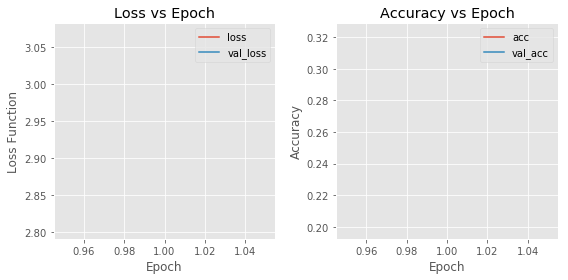

5740/5740 [==============================] - 7392s - loss: 2.8040 - acc: 0.3225 - val_loss: 3.0684 - val_acc: 0.1987
                                          

In [98]:

# fit
model_resnext1d.fit(X_train, Y_train,
                    batch_size=5, epochs=1, verbose=1,
                    callbacks=[DualPlotCallback(log_file_path=my_log_file_path, 
                                                log_fig_path=my_log_fig_path)],
                    validation_data=(X_test, Y_test),
                    shuffle="batch")
#model_resnext1d.summary()

# sleep after training
computer_sleep(seconds_until_sleep=10, verbose=1)

    iter     loss
    70       3.2
    235      3.1
    845      3.0
    2045     2.9
    3___     2.8


# ...

# ...

# ... Try Model

In [104]:
#import resnext

In [105]:
#resnext.__file__

In [107]:
###UNDO EDIT###

# ...

# ... Have ResNext1D infer classes=Y_train.shape[1]

In [111]:
inpu = chunk_tuple[1:]
dept = 11
card = 1 # 3
widt = 32 # 64
weig = 5e-4
clas = Y_train.shape[1]

model_resnext1d = ResNext1D(input_shape=inpu, 
                            depth=dept,
                            cardinality=card,
                            width=widt,
                            weight_decay=weig, 
                            classes=clas)   

model_resnext1d.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model_resnext1d.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_21 (InputLayer)            (None, 88200, 1)      0                                            
____________________________________________________________________________________________________
random_cropping1d_12 (RandomCrop (None, 22050, 1)      0           input_21[0][0]                   
____________________________________________________________________________________________________
conv1d_270 (Conv1D)              (None, 22050, 32)     32          random_cropping1d_12[0][0]       
____________________________________________________________________________________________________
batch_normalization_234 (BatchNo (None, 22050, 32)     128         conv1d_270[0][0]                 
___________________________________________________________________________________________

first: card = 2, widt = 64

    Total params: 2,241,984
    Trainable params: 2,231,104
    Non-trainable params: 10,880

second: card = 1, widt = 64

    Total params: 703,424
    Trainable params: 697,920
    Non-trainable params: 5,504

third: card = 1, widt = 32

    Total params: 178,624
    Trainable params: 175,936
    Non-trainable params: 2,688


fourth: card = 3, widt = 32

    Total params: 1,174,720
    Trainable params: 1,166,528
    Non-trainable params: 8,192


New (1): cropping=int(global_sr * 1)
    
    Total params: 1,156,128
    Trainable params: 1,148,064
    Non-trainable params: 8,064

New (2): cropping=int(global_sr * 0.10)
    
    Total params: 1,156,128
    Trainable params: 1,148,064
    Non-trainable params: 8,064

New (3): dept = 11, card = 1

    Total params: 176,480
    Trainable params: 173,792
    Non-trainable params: 2,688
    
New (3): dept = 11, card = 1





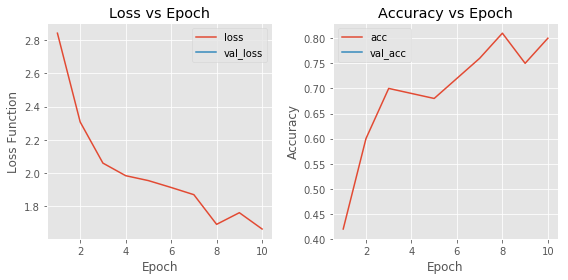

100/100 [==============================] - 109s - loss: 1.6624 - acc: 0.8000   
                                          

In [113]:
# fit
model_resnext1d.fit(X_train, Y_train,
          batch_size=2, epochs=10, verbose=1,
          callbacks=[DualPlotCallback(log_file_path=my_log_file_path, 
                                           log_fig_path=my_log_fig_path)])
#model_resnext1d.summary()

# sleep after training
computer_sleep(seconds_until_sleep=10, verbose=1)

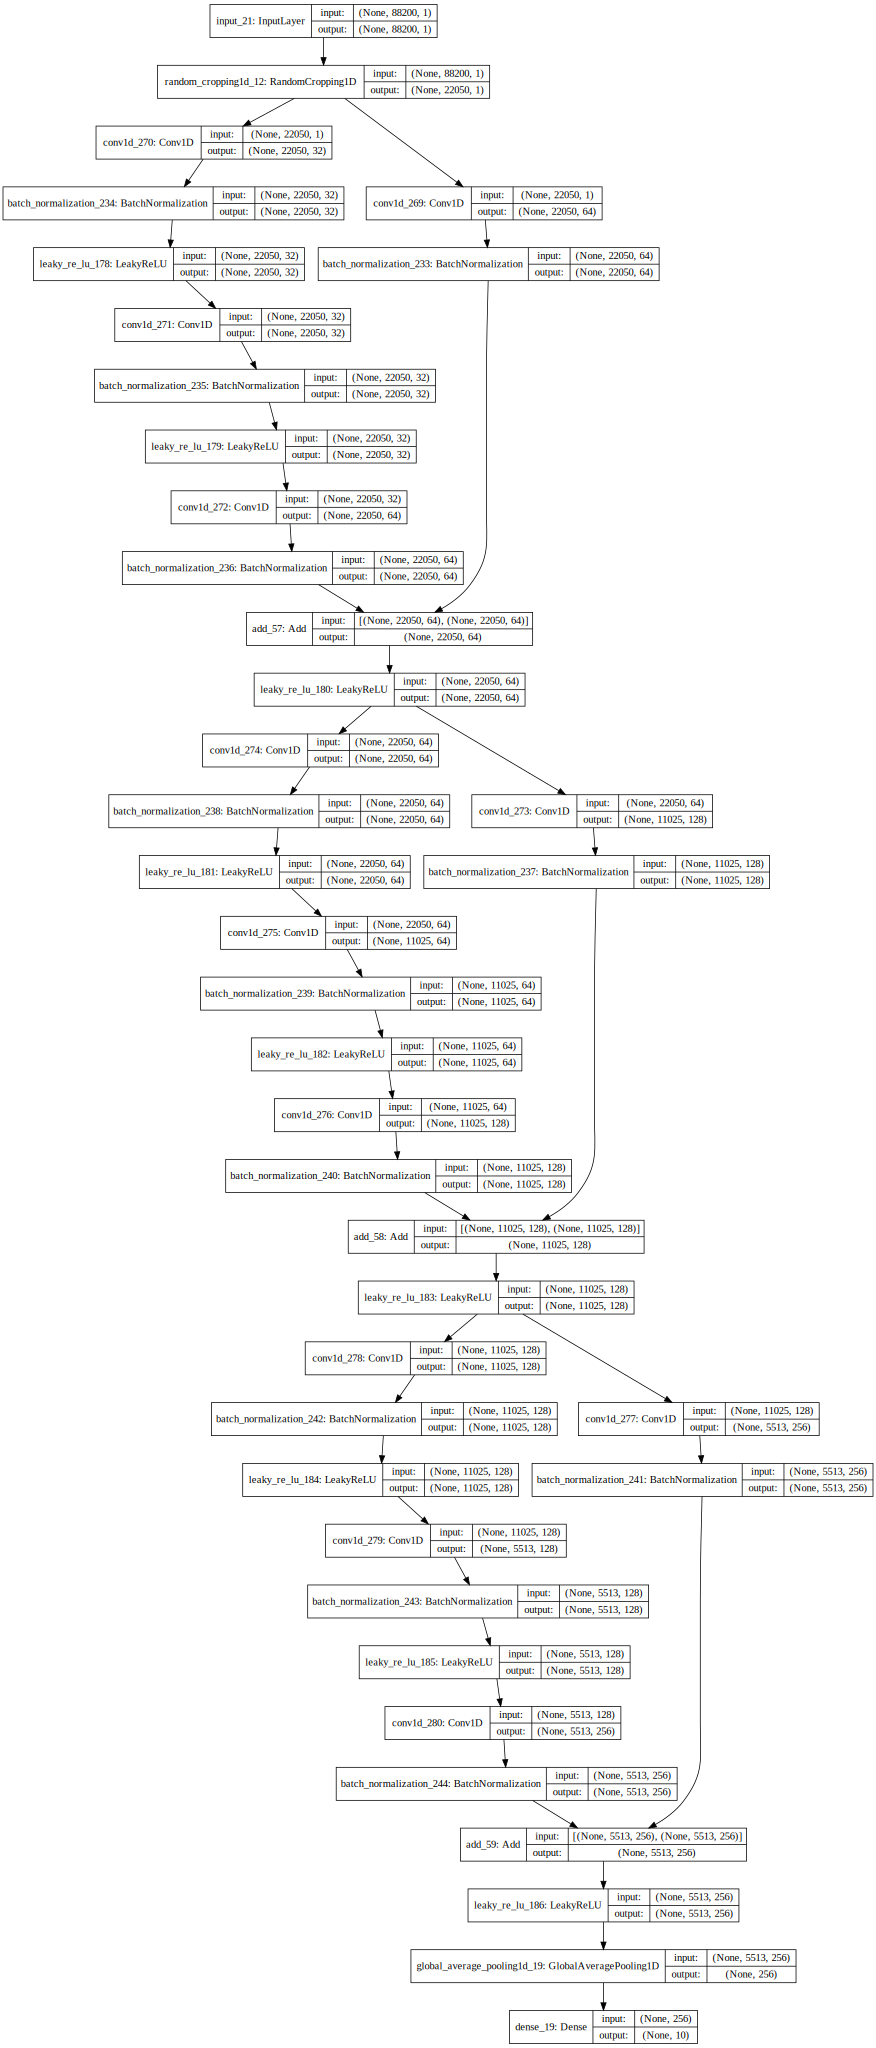

In [112]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_resnext1d, 
                 show_layer_names=True, 
                 show_shapes=True).create(prog='dot', format='svg'))


# ....

In [31]:
log_file_fn = 'log_trash.csv'
my_log_file_path = os.path.join(interim_trash_dir, log_file_fn)

log_fig_fn = 'log_fig.png'
my_log_fig_path = os.path.join(interim_trash_dir, log_fig_fn)

In [32]:
model_resnext1d.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model_resnext1d.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 88200, 1)      0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 88200, 64)     192         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 88200, 64)     256         conv1d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 88200, 64)     0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

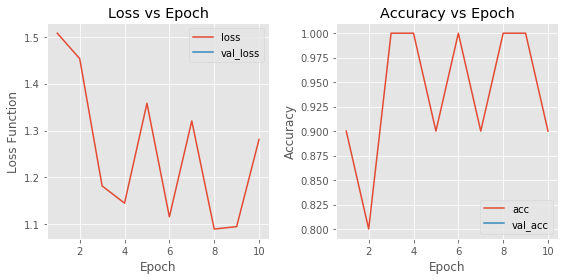

10/10 [==============================] - 2s - loss: 1.2811 - acc: 0.9000     
                                          

In [93]:
# fit
model_resnext1d.fit(X_train, Y_train,
          batch_size=2, epochs=10, verbose=1,
          callbacks=[DualPlotCallback(log_file_path=my_log_file_path, 
                                           log_fig_path=my_log_fig_path)])
#model_resnext1d.summary()

# sleep after training
computer_sleep(seconds_until_sleep=10, verbose=1)

# ...

In [ ]:
'''ResNeXt models for Keras.
# Reference
- [Aggregated Residual Transformations for Deep Neural Networks](https://arxiv.org/pdf/1611.05431.pdf))
'''
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings

from keras.models import Model
from keras.layers.core import Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
#from keras.layers.convolutional import Conv2D
#from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D

from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalAveragePooling1D, GlobalMaxPool1D, MaxPool1D

from keras.layers import Input
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
#from keras.applications.imagenet_utils import _obtain_input_shape
import keras.backend as K


def ResNext1D(input_shape=None, depth=29, cardinality=8, width=64, weight_decay=5e-4,
              include_top=True, weights=None, input_tensor=None,
              pooling=None, classes=10):
    """Instantiate the ResNeXt architecture. Note that ,
        when using TensorFlow for best performance you should set
        `image_data_format="channels_last"` in your Keras config
        at ~/.keras/keras.json.
        The model are compatible with both
        TensorFlow and Theano. The dimension ordering
        convention used by the model is the one
        specified in your Keras config file.
        # Arguments
            depth: number or layers in the ResNeXt model. Can be an
                integer or a list of integers.
            cardinality: the size of the set of transformations
            width: multiplier to the ResNeXt width (number of filters)
            weight_decay: weight decay (l2 norm)
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: `None` (random initialization)
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False 
        #                (otherwise the input shape
        #                has to be `(32, 32, 3)` (with `tf` dim ordering)
        #                or `(3, 32, 32)` (with `th` dim ordering).
        #                It should have exactly 3 inputs channels,
        #                and width and height should be no smaller than 8.
        #                E.g. `(200, 200, 3)` would be one valid value.
            pooling: Optional pooling mode for feature extraction
                when `include_top` is `False`.
                - `None` means that the output of the model will be
                    the 4D tensor output of the
                    last convolutional layer.
                - `avg` means that global average pooling
                    will be applied to the output of the
                    last convolutional layer, and thus
                    the output of the model will be a 2D tensor.
                - `max` means that global max pooling will
                    be applied.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
        # Returns
            A Keras model instance.
        """

    if type(depth) == int:
        if (depth - 2) % 9 != 0:
            raise ValueError('Depth of the network must be such that (depth - 2)'
                             'should be divisible by 9.')


#    if input_tensor is None:
#        img_input = Input(shape=input_shape)
#    else:
#        if not K.is_keras_tensor(input_tensor):
#            img_input = Input(tensor=input_tensor, shape=input_shape)
#        else:
#            img_input = input_tensor


    # RENAME img_input
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    
    x = __create_res_next(classes, img_input, include_top, depth, cardinality, width, weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnext')

    return model


def __initial_conv_block(input, weight_decay=5e-4):
    ''' Adds an initial convolution block, with batch normalization and relu activation
    Args:
        input: input tensor
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
#EDIT    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

#    x = Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_initializer='he_normal',
#               kernel_regularizer=l2(weight_decay))(input)

    x = Conv1D(64, 3, padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(input)
#
    x = BatchNormalization(axis=channel_axis)(x)
    x = LeakyReLU()(x)

    return x

def __initial_conv_block_inception(input, weight_decay=5e-4):
    ''' Adds an initial conv block, with batch norm and relu for the inception resnext
    Args:
        input: input tensor
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
# EDIT    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

#

#    x = Conv2D(64, (7, 7), padding='same', use_bias=False, kernel_initializer='he_normal',
#               kernel_regularizer=l2(weight_decay), strides=(2, 2))(input)

    x = Conv1D(64, 7, padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay), strides=2)(input)
#    
    x = BatchNormalization(axis=channel_axis)(x)
    x = LeakyReLU()(x)

#    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    
    return x



def __initial_conv_block_inception(input, weight_decay=5e-4):
    ''' Adds an initial conv block, with batch norm and relu for the inception resnext
    Args:
        input: input tensor
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
# EDIT    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

#

#    x = Conv2D(64, (7, 7), padding='same', use_bias=False, kernel_initializer='he_normal',
#               kernel_regularizer=l2(weight_decay), strides=(2, 2))(input)

    x = Conv1D(64, 7, padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay), strides=2)(input)
#    
    x = BatchNormalization(axis=channel_axis)(x)
    x = LeakyReLU()(x)

#    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    
    return x


def __grouped_convolution_block(input, grouped_channels, cardinality, strides, weight_decay=5e-4):
    ''' Adds a grouped convolution block. It is an equivalent block from the paper
    Args:
        input: input tensor
        grouped_channels: grouped number of filters
        cardinality: cardinality factor describing the number of groups
        strides: performs strided convolution for downscaling if > 1
        weight_decay: weight decay term
    Returns: a keras tensor
    '''
    init = input
# EDIT    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    group_list = []

    if cardinality == 1:
        # with cardinality 1, it is a standard convolution
#        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
#                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
        
        x = Conv1D(grouped_channels, 3, padding='same', use_bias=False, strides=strides,
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)

        x = BatchNormalization(axis=channel_axis)(x)
        x = LeakyReLU()(x)
        return x

    for c in range(cardinality):
#        x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels]
#                   if K.image_data_format() == 'channels_last' else
#                   lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :, :])(input)

        x = Lambda(lambda z: z[:, :, c * grouped_channels:(c + 1) * grouped_channels]
                   if K.image_data_format() == 'channels_last' else
                   lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :])(input)

#        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
#                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

# INDENT
        x = Conv1D(grouped_channels, 3, padding='same', use_bias=False, strides=strides, kernel_initializer='he_normal', 
                   kernel_regularizer=l2(weight_decay))(x)

        group_list.append(x)

    group_merge = concatenate(group_list, axis=channel_axis)
    x = BatchNormalization(axis=channel_axis)(group_merge)
    x = LeakyReLU()(x)

    return x


def __bottleneck_block(input, filters=64, cardinality=8, strides=1, weight_decay=5e-4):
    ''' Adds a bottleneck block
    Args:
        input: input tensor
        filters: number of output filters
        cardinality: cardinality factor described number of
            grouped convolutions
        strides: performs strided convolution for downsampling if > 1
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
    init = input

    grouped_channels = int(filters / cardinality)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 16 * k, else create convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init._keras_shape[1] != 2 * filters:
#            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
#                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
#
            init = Conv1D(filters * 2, 1, padding='same', strides=strides,
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)

            init = BatchNormalization(axis=channel_axis)(init)
    else:
        if init._keras_shape[-1] != 2 * filters:
#            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
#                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)

            init = Conv1D(filters * 2, 1, padding='same', strides=strides,
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)

            init = BatchNormalization(axis=channel_axis)(init)

#    x = Conv2D(filters, (1, 1), padding='same', use_bias=False,
#               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)

#INDENT
    x = Conv1D(filters, 1, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)

    x = BatchNormalization(axis=channel_axis)(x)
    x = LeakyReLU()(x)

    x = __grouped_convolution_block(x, grouped_channels, cardinality, strides, weight_decay)

    #    x = Conv2D(filters * 2, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
    #               kernel_regularizer=l2(weight_decay))(x)

    x = Conv1D(filters * 2, 1, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

    x = BatchNormalization(axis=channel_axis)(x)

    x = add([init, x])
    x = LeakyReLU()(x)

    return x


def __create_res_next(nb_classes, img_input, include_top, depth=29, cardinality=8, width=4,
                      weight_decay=5e-4, pooling=None):
    ''' Creates a ResNeXt model with specified parameters
    Args:
        nb_classes: Number of output classes
        img_input: Input tensor or layer
        include_top: Flag to include the last dense layer
        depth: Depth of the network. Can be an positive integer or a list
               Compute N = (n - 2) / 9.
               For a depth of 56, n = 56, N = (56 - 2) / 9 = 6
               For a depth of 101, n = 101, N = (101 - 2) / 9 = 11
        cardinality: the size of the set of transformations.
               Increasing cardinality improves classification accuracy,
        width: Width of the network.
        weight_decay: weight_decay (l2 norm)
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
    Returns: a Keras Model
    '''

    if type(depth) is list or type(depth) is tuple:
        # If a list is provided, defer to user how many blocks are present
        N = list(depth)
    else:
        # Otherwise, default to 3 blocks each of default number of group convolution blocks
        N = [(depth - 2) // 9 for _ in range(3)]

    filters = cardinality * width
    filters_list = []

    for i in range(len(N)):
        filters_list.append(filters)
        filters *= 2  # double the size of the filters

    x = __initial_conv_block(img_input, weight_decay)

    # block 1 (no pooling)
    for i in range(N[0]):
        x = __bottleneck_block(x, filters_list[0], cardinality, strides=1, weight_decay=weight_decay)

    N = N[1:]  # remove the first block from block definition list
    filters_list = filters_list[1:]  # remove the first filter from the filter list

    # block 2 to N
    for block_idx, n_i in enumerate(N):
        for i in range(n_i):
            if i == 0:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=2,
                                       weight_decay=weight_decay)
            else:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=1,
                                       weight_decay=weight_decay)

                
    if include_top:
#        x = GlobalAveragePooling2D()(x)

        x = GlobalAveragePooling1D()(x)

        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  kernel_initializer='he_normal', activation='softmax')(x)
    else:
        if pooling == 'avg':
#            x = GlobalAveragePooling2D()(x)

            x = GlobalAveragePooling1D()(x)
            
        elif pooling == 'max':
#            x = GlobalMaxPooling2D()(x)

            x = GlobalMaxPooling1D()(x)
                
                
                
#    if include_top:
#        x = GlobalAveragePooling2D()(x)
#        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
#                  kernel_initializer='he_normal', activation='softmax')(x)
#    else:
#        if pooling == 'avg':
#            x = GlobalAveragePooling2D()(x)
#        elif pooling == 'max':
#            x = GlobalMaxPooling2D()(x)

    return x



# ..

In [ ]:

log_file_fn = 'log_trash.csv'
my_log_file_path = os.path.join(interim_trash_dir, log_file_fn)

log_fig_fn = 'log_fig.png'
my_log_fig_path = os.path.join(interim_trash_dir, log_fig_fn)

############

model = Sequential()

model.add(Activation(None, input_shape=(88200, 1)))
model.add(RandomCropping1D(cropping=(global_sr * 3)))#66150))

#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same',
#                        input_shape=(1, img_rows, img_cols)))

#model.add(cropping.Cropping2D(cropping=((2,2),(2,2))))
#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same'))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(img_rows/2, img_cols/2)))

model.add(Flatten())
model.add(Dense(Y_train.shape[1]))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

# fit
model.fit(X_train, Y_train,
          batch_size=5, epochs=10, verbose=1,
          callbacks=[DualPlotCallback(log_file_path=my_log_file_path, 
                                           log_fig_path=my_log_fig_path)])
model.summary()

# sleep after training
computer_sleep(seconds_until_sleep=10, verbose=1)

# ...

In [61]:
'''ResNeXt models for Keras.
# Reference
- [Aggregated Residual Transformations for Deep Neural Networks](https://arxiv.org/pdf/1611.05431.pdf))
'''
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings

from keras.models import Model
from keras.layers.core import Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
#from keras.layers.convolutional import Conv2D
#from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D

from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalAveragePooling1D, GlobalMaxPool1D, MaxPool1D

from keras.layers import Input
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
#from keras.applications.imagenet_utils import _obtain_input_shape
import keras.backend as K



def ResNext1D(input_shape=None, depth=29, cardinality=8, width=64, weight_decay=5e-4,
              include_top=True, weights=None, input_tensor=None,
              pooling=None, classes=10):
    """Instantiate the ResNeXt architecture. Note that ,
        when using TensorFlow for best performance you should set
        `image_data_format="channels_last"` in your Keras config
        at ~/.keras/keras.json.
        The model are compatible with both
        TensorFlow and Theano. The dimension ordering
        convention used by the model is the one
        specified in your Keras config file.
        # Arguments
            depth: number or layers in the ResNeXt model. Can be an
                integer or a list of integers.
            cardinality: the size of the set of transformations
            width: multiplier to the ResNeXt width (number of filters)
            weight_decay: weight decay (l2 norm)
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: `None` (random initialization)
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False 
        #                (otherwise the input shape
        #                has to be `(32, 32, 3)` (with `tf` dim ordering)
        #                or `(3, 32, 32)` (with `th` dim ordering).
        #                It should have exactly 3 inputs channels,
        #                and width and height should be no smaller than 8.
        #                E.g. `(200, 200, 3)` would be one valid value.
            pooling: Optional pooling mode for feature extraction
                when `include_top` is `False`.
                - `None` means that the output of the model will be
                    the 4D tensor output of the
                    last convolutional layer.
                - `avg` means that global average pooling
                    will be applied to the output of the
                    last convolutional layer, and thus
                    the output of the model will be a 2D tensor.
                - `max` means that global max pooling will
                    be applied.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
        # Returns
            A Keras model instance.
        """

    if type(depth) == int:
        if (depth - 2) % 9 != 0:
            raise ValueError('Depth of the network must be such that (depth - 2)'
                             'should be divisible by 9.')


#    if input_tensor is None:
#        img_input = Input(shape=input_shape)
#    else:
#        if not K.is_keras_tensor(input_tensor):
#            img_input = Input(tensor=input_tensor, shape=input_shape)
#        else:
#            img_input = input_tensor


    # RENAME img_input
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    
    x = __create_res_next(classes, img_input, include_top, depth, cardinality, width, weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnext')

    return model


def __initial_conv_block(input, weight_decay=5e-4):
    ''' Adds an initial convolution block, with batch normalization and relu activation
    Args:
        input: input tensor
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
#EDIT    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

#    x = Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_initializer='he_normal',
#               kernel_regularizer=l2(weight_decay))(input)

    x = Conv1D(64, 3, padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(input)
#
    x = BatchNormalization(axis=channel_axis)(x)
    x = LeakyReLU()(x)

    return x


def __initial_conv_block_inception(input, weight_decay=5e-4):
    ''' Adds an initial conv block, with batch norm and relu for the inception resnext
    Args:
        input: input tensor
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
# EDIT    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

#

#    x = Conv2D(64, (7, 7), padding='same', use_bias=False, kernel_initializer='he_normal',
#               kernel_regularizer=l2(weight_decay), strides=(2, 2))(input)

    x = Conv1D(64, 7, padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay), strides=2)(input)
#    
    x = BatchNormalization(axis=channel_axis)(x)
    x = LeakyReLU()(x)

#    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    
    return x


def __grouped_convolution_block(input, grouped_channels, cardinality, strides, weight_decay=5e-4):
    ''' Adds a grouped convolution block. It is an equivalent block from the paper
    Args:
        input: input tensor
        grouped_channels: grouped number of filters
        cardinality: cardinality factor describing the number of groups
        strides: performs strided convolution for downscaling if > 1
        weight_decay: weight decay term
    Returns: a keras tensor
    '''
    init = input
# EDIT    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    group_list = []

    if cardinality == 1:
        # with cardinality 1, it is a standard convolution
#        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
#                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
        
        x = Conv1D(grouped_channels, 3, padding='same', use_bias=False, strides=strides,
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)

        x = BatchNormalization(axis=channel_axis)(x)
        x = LeakyReLU()(x)
        return x

    for c in range(cardinality):
#        x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels]
#                   if K.image_data_format() == 'channels_last' else
#                   lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :, :])(input)

        x = Lambda(lambda z: z[:, :, c * grouped_channels:(c + 1) * grouped_channels]
                   if K.image_data_format() == 'channels_last' else
                   lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :])(input)

#        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
#                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

# INDENT
        x = Conv1D(grouped_channels, 3, padding='same', use_bias=False, strides=strides, kernel_initializer='he_normal', 
                   kernel_regularizer=l2(weight_decay))(x)

        group_list.append(x)

    group_merge = concatenate(group_list, axis=channel_axis)
    x = BatchNormalization(axis=channel_axis)(group_merge)
    x = LeakyReLU()(x)

    return x


def __bottleneck_block(input, filters=64, cardinality=8, strides=1, weight_decay=5e-4):
    ''' Adds a bottleneck block
    Args:
        input: input tensor
        filters: number of output filters
        cardinality: cardinality factor described number of
            grouped convolutions
        strides: performs strided convolution for downsampling if > 1
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
    init = input

    grouped_channels = int(filters / cardinality)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 16 * k, else create convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init._keras_shape[1] != 2 * filters:
#            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
#                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
#
            init = Conv1D(filters * 2, 1, padding='same', strides=strides,
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)

            init = BatchNormalization(axis=channel_axis)(init)
    else:
        if init._keras_shape[-1] != 2 * filters:
#            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
#                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)

            init = Conv1D(filters * 2, 1, padding='same', strides=strides,
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)

            init = BatchNormalization(axis=channel_axis)(init)

#    x = Conv2D(filters, (1, 1), padding='same', use_bias=False,
#               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)

#INDENT
    x = Conv1D(filters, 1, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)

    x = BatchNormalization(axis=channel_axis)(x)
    x = LeakyReLU()(x)

    x = __grouped_convolution_block(x, grouped_channels, cardinality, strides, weight_decay)

    #    x = Conv2D(filters * 2, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
    #               kernel_regularizer=l2(weight_decay))(x)

    x = Conv1D(filters * 2, 1, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

    x = BatchNormalization(axis=channel_axis)(x)

    x = add([init, x])
    x = LeakyReLU()(x)

    return x


def __create_res_next(nb_classes, img_input, include_top, depth=29, cardinality=8, width=4,
                      weight_decay=5e-4, pooling=None):
    ''' Creates a ResNeXt model with specified parameters
    Args:
        nb_classes: Number of output classes
        img_input: Input tensor or layer
        include_top: Flag to include the last dense layer
        depth: Depth of the network. Can be an positive integer or a list
               Compute N = (n - 2) / 9.
               For a depth of 56, n = 56, N = (56 - 2) / 9 = 6
               For a depth of 101, n = 101, N = (101 - 2) / 9 = 11
        cardinality: the size of the set of transformations.
               Increasing cardinality improves classification accuracy,
        width: Width of the network.
        weight_decay: weight_decay (l2 norm)
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
    Returns: a Keras Model
    '''

    if type(depth) is list or type(depth) is tuple:
        # If a list is provided, defer to user how many blocks are present
        N = list(depth)
    else:
        # Otherwise, default to 3 blocks each of default number of group convolution blocks
        N = [(depth - 2) // 9 for _ in range(3)]

    filters = cardinality * width
    filters_list = []

    for i in range(len(N)):
        filters_list.append(filters)
        filters *= 2  # double the size of the filters

    x = __initial_conv_block(img_input, weight_decay)

    # block 1 (no pooling)
    for i in range(N[0]):
        x = __bottleneck_block(x, filters_list[0], cardinality, strides=1, weight_decay=weight_decay)

    N = N[1:]  # remove the first block from block definition list
    filters_list = filters_list[1:]  # remove the first filter from the filter list

    # block 2 to N
    for block_idx, n_i in enumerate(N):
        for i in range(n_i):
            if i == 0:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=2,
                                       weight_decay=weight_decay)
            else:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=1,
                                       weight_decay=weight_decay)

                
    if include_top:
#        x = GlobalAveragePooling2D()(x)

        x = GlobalAveragePooling1D()(x)

        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  kernel_initializer='he_normal', activation='softmax')(x)
    else:
        if pooling == 'avg':
#            x = GlobalAveragePooling2D()(x)

            x = GlobalAveragePooling1D()(x)
            
        elif pooling == 'max':
#            x = GlobalMaxPooling2D()(x)

            x = GlobalMaxPooling1D()(x)
                
                
                
#    if include_top:
#        x = GlobalAveragePooling2D()(x)
#        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
#                  kernel_initializer='he_normal', activation='softmax')(x)
#    else:
#        if pooling == 'avg':
#            x = GlobalAveragePooling2D()(x)
#        elif pooling == 'max':
#            x = GlobalMaxPooling2D()(x)

    return x



In [62]:
print(chunk_tuple)
print(chunk_tuple[1:])

(1, 88200, 1)
(88200, 1)


In [64]:
#model_resnext1d = ResNext1D(chunk_tuple[1:])

In [88]:
inpu = chunk_tuple[1:]
dept = 11
card = 2
widt = 64
weig = 5e-4
#clas = 10

model_resnext1d = ResNext1D(input_shape=inpu, 
                            depth=dept,
                            cardinality=card,
                            width=widt,
                            weight_decay=weig)#, 
#                            classes=clas)                        

In [54]:
model_to_dot(model_resnext1d).create?

Object `create` not found.


In [ ]:
model_to_dot(model_resnext1d).create

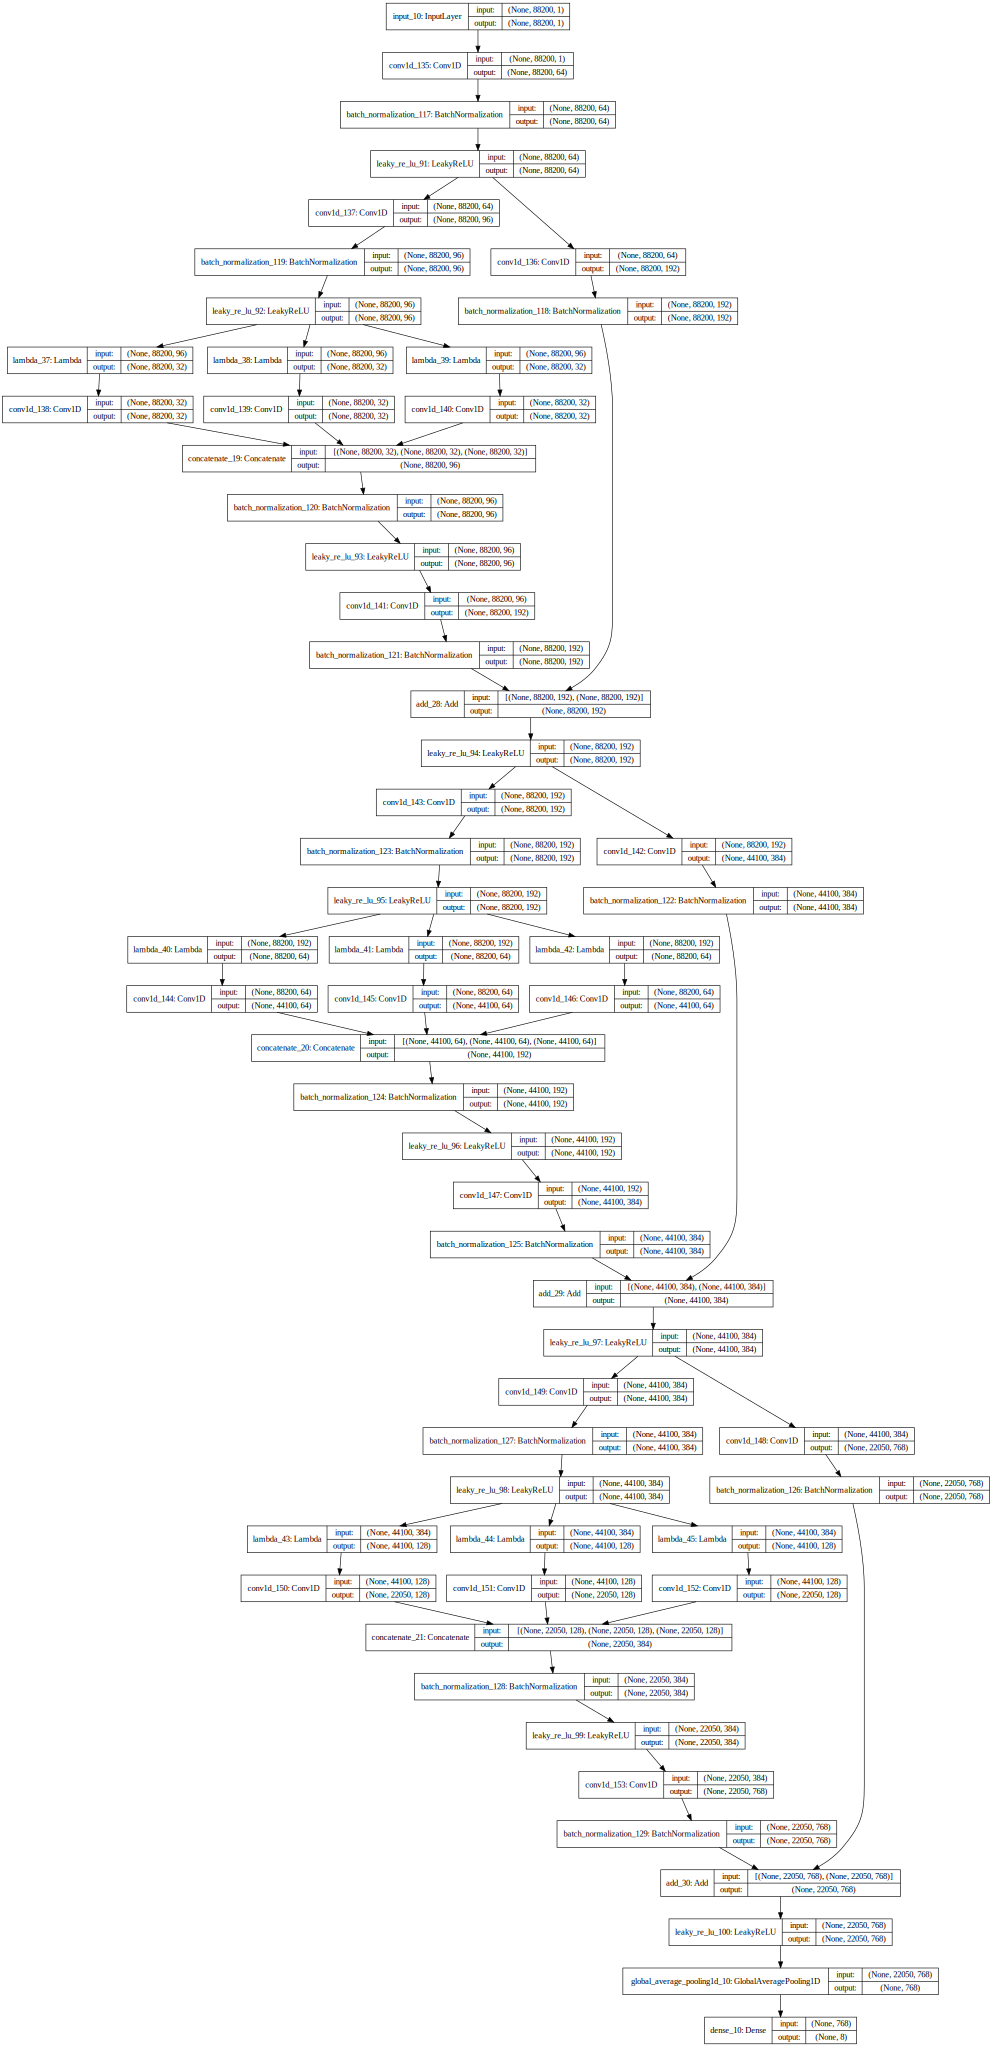

In [59]:
SVG(model_to_dot(model_resnext1d, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

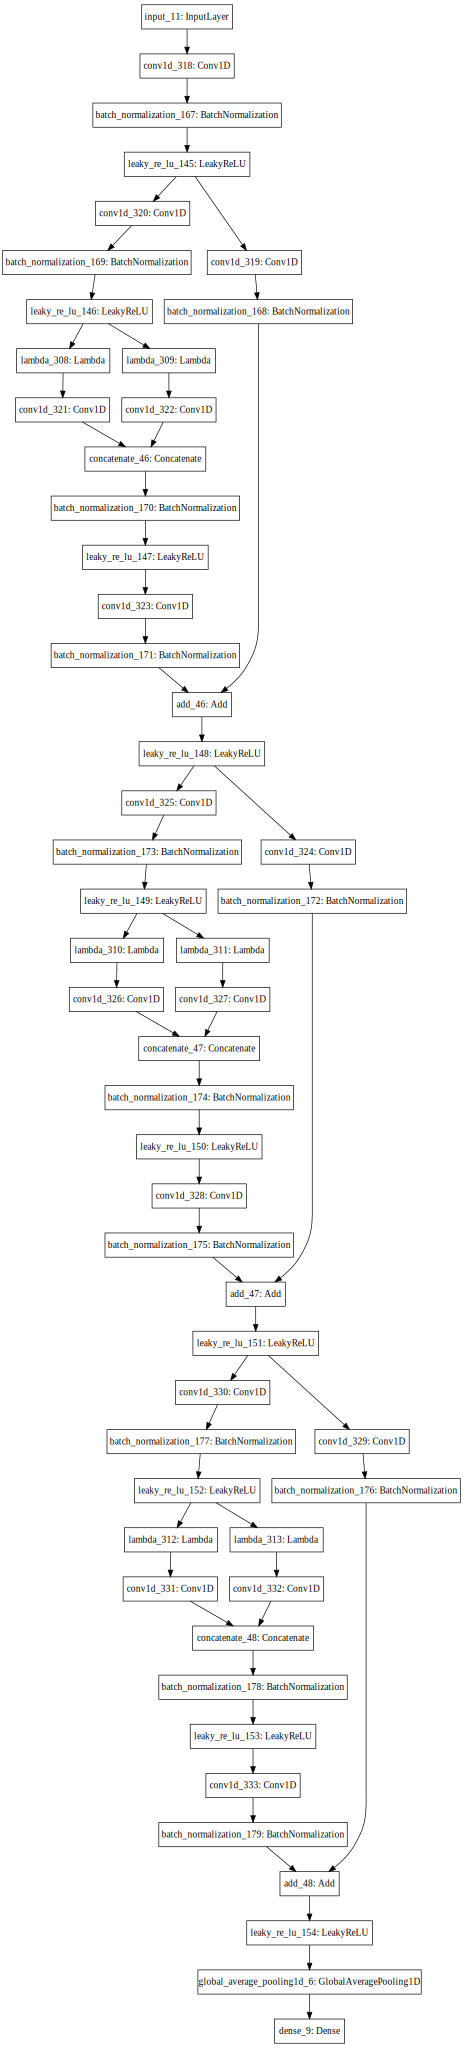

In [89]:
SVG(model_to_dot(model_resnext1d).create(prog='dot', format='svg'))

In [ ]:
print(chunk_tuple)
print(chunk_tuple[1:])

inpu = chunk_tuple[1:]
dept = 11
card = 2
widt = 64
weig = 5e-4
clas = 10

model_resnext1d = ResNext1D(input_shape=inpu, 
                            depth=dept,
                            cardinality=card,
                            width=widt,
                            weight_decay=weig, 
                            classes=clas)     

SVG(model_to_dot(model_resnext1d).create(prog='dot', format='svg'))




log_file_fn = 'log_trash.csv'
my_log_file_path = os.path.join(interim_trash_dir, log_file_fn)

log_fig_fn = 'log_fig.png'
my_log_fig_path = os.path.join(interim_trash_dir, log_fig_fn)

############

model = Sequential()

model.add(Activation(None, input_shape=(88200, 1)))
model.add(RandomCropping1D(cropping=(global_sr * 3)))#66150))

#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same',
#                        input_shape=(1, img_rows, img_cols)))

#model.add(cropping.Cropping2D(cropping=((2,2),(2,2))))
#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same'))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(img_rows/2, img_cols/2)))

model.add(Flatten())
model.add(Dense(Y_train.shape[1]))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

# fit
model.fit(X_train, Y_train,
          batch_size=5, epochs=10, verbose=1,
          callbacks=[DualPlotCallback(log_file_path=my_log_file_path, 
                                           log_fig_path=my_log_fig_path)])
model.summary()

# sleep after training
computer_sleep(seconds_until_sleep=10, verbose=1)

In [44]:

def ResNext1D(input_shape=None, depth=29, cardinality=8, width=64, weight_decay=5e-4,
              include_top=True, weights=None, input_tensor=None,
              pooling=None, classes=10):
    """Instantiate the ResNeXt architecture. Note that ,
        when using TensorFlow for best performance you should set
        `image_data_format="channels_last"` in your Keras config
        at ~/.keras/keras.json.
        The model are compatible with both
        TensorFlow and Theano. The dimension ordering
        convention used by the model is the one
        specified in your Keras config file.
        # Arguments
            depth: number or layers in the ResNeXt model. Can be an
                integer or a list of integers.
            cardinality: the size of the set of transformations
            width: multiplier to the ResNeXt width (number of filters)
            weight_decay: weight decay (l2 norm)
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: `None` (random initialization)
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False 
        #                (otherwise the input shape
        #                has to be `(32, 32, 3)` (with `tf` dim ordering)
        #                or `(3, 32, 32)` (with `th` dim ordering).
        #                It should have exactly 3 inputs channels,
        #                and width and height should be no smaller than 8.
        #                E.g. `(200, 200, 3)` would be one valid value.
            pooling: Optional pooling mode for feature extraction
                when `include_top` is `False`.
                - `None` means that the output of the model will be
                    the 4D tensor output of the
                    last convolutional layer.
                - `avg` means that global average pooling
                    will be applied to the output of the
                    last convolutional layer, and thus
                    the output of the model will be a 2D tensor.
                - `max` means that global max pooling will
                    be applied.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
        # Returns
            A Keras model instance.
        """

    if type(depth) == int:
        if (depth - 2) % 9 != 0:
            raise ValueError('Depth of the network must be such that (depth - 2)'
                             'should be divisible by 9.')


#    if input_tensor is None:
#        img_input = Input(shape=input_shape)
#    else:
#        if not K.is_keras_tensor(input_tensor):
#            img_input = Input(tensor=input_tensor, shape=input_shape)
#        else:
#            img_input = input_tensor


    # RENAME img_input
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    
    x = __create_res_next(classes, img_input, include_top, depth, cardinality, width, weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnext')

    return model



In [56]:
print(chunk_tuple)
print(chunk_tuple[1:])
ResNext1D(chunk_tuple[1:])

(1, 88200, 1)
(88200, 1)


In [71]:
ResNext1D(chunk_tuple[1:])

In [ ]:
#from keras.layers.convolutional import Conv2D
#from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D

from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalAveragePooling1D, GlobalMaxPool1D, MaxPool1D


from keras.layers import Input
help(Input)

In [33]:
inpu = (112, 112, 3)
dept = 11
card = 2
widt = 64
weig = 5e-4
clas = 10


model = resnext.ResNext(input_shape=inpu, 
                        depth=dept,
                        cardinality=card,
                        width=widt,
                        weight_decay=weig, 
                        classes=clas)
                        
                        

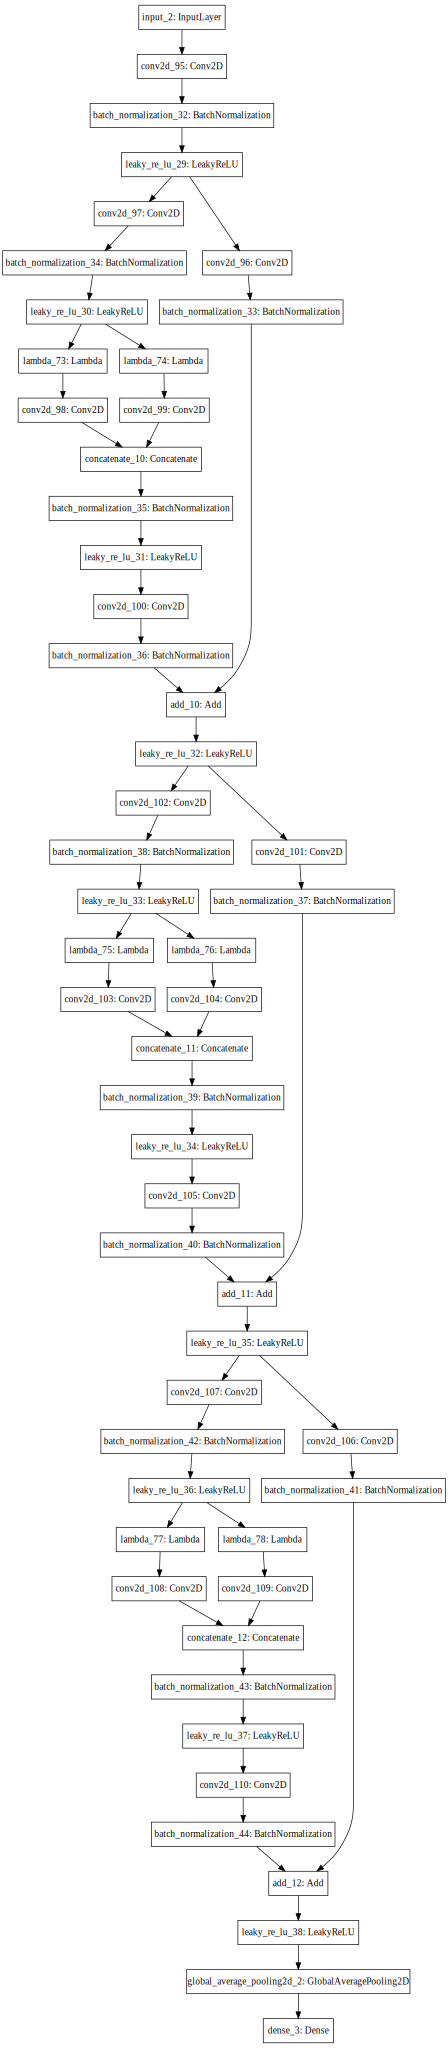

In [34]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [26]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


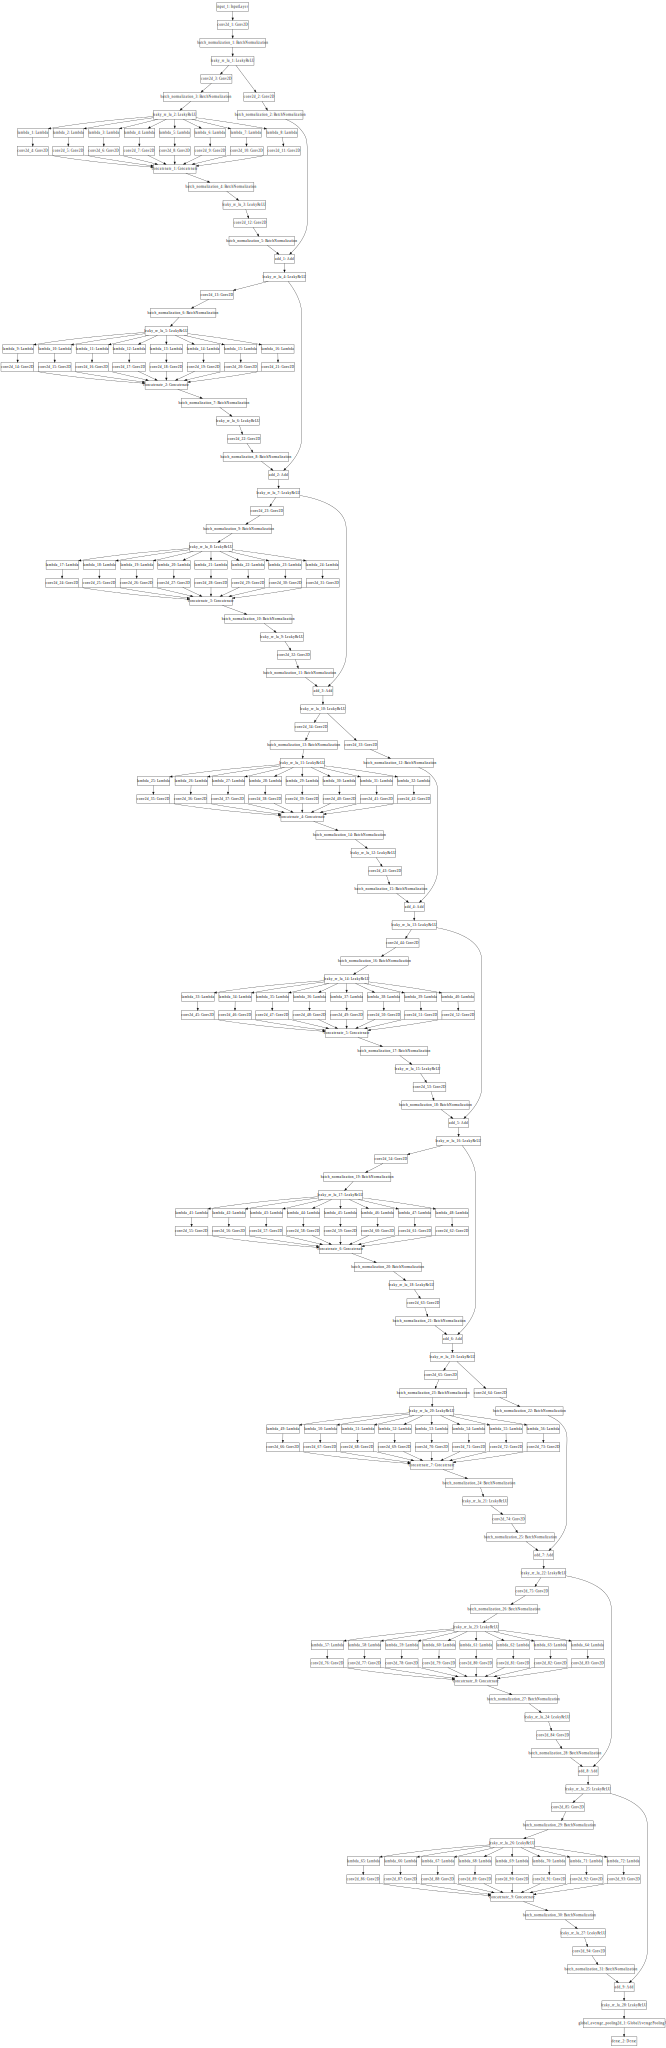

In [32]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
log_file_fn = 'log_trash.csv'
my_log_file_path = os.path.join(interim_trash_dir, log_file_fn)

log_fig_fn = 'log_fig.png'
my_log_fig_path = os.path.join(interim_trash_dir, log_fig_fn)

############

model = Sequential()

model.add(Activation(None, input_shape=(88200, 1)))
model.add(RandomCropping1D(cropping=(global_sr * 3)))#66150))

#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same',
#                        input_shape=(1, img_rows, img_cols)))

#model.add(cropping.Cropping2D(cropping=((2,2),(2,2))))
#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same'))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(img_rows/2, img_cols/2)))

model.add(Flatten())
model.add(Dense(Y_train.shape[1]))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

# fit
model.fit(X_train, Y_train,
          batch_size=5, epochs=10, verbose=1,
          callbacks=[DualPlotCallback(log_file_path=my_log_file_path, 
                                           log_fig_path=my_log_fig_path)])
model.summary()

# sleep after training
computer_sleep(seconds_until_sleep=10, verbose=1)

# ...

In [17]:
from models.randomcrop import RandomCropping1D
from models.dualplotcallback import DualPlotCallback
from utils.bedtime import computer_sleep

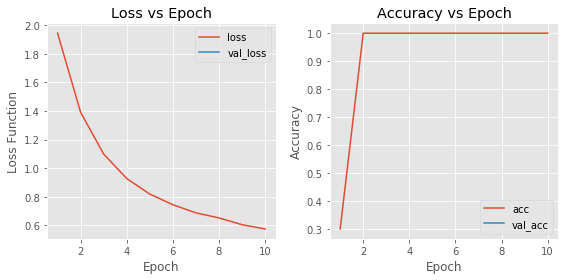

10/10 [==============================] - 1s - loss: 0.5752 - acc: 1.0000     
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 88200, 1)          0         
_________________________________________________________________
random_cropping1d_1 (RandomC (None, 66150, 1)          0         
_________________________________________________________________
activation_2 (Activation)    (None, 66150, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 66150)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 529208    
_________________________________________________________________
activation_3 (Activation)    (None, 8)                 0         
Total params: 529,208
Trainable params: 529,208
Non-trainable pa

In [21]:
log_file_fn = 'log_trash.csv'
my_log_file_path = os.path.join(interim_trash_dir, log_file_fn)

log_fig_fn = 'log_fig.png'
my_log_fig_path = os.path.join(interim_trash_dir, log_fig_fn)

############

model = Sequential()

model.add(Activation(None, input_shape=(88200, 1)))
model.add(RandomCropping1D(cropping=(global_sr * 3)))#66150))

#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same',
#                        input_shape=(1, img_rows, img_cols)))

#model.add(cropping.Cropping2D(cropping=((2,2),(2,2))))
#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same'))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(img_rows/2, img_cols/2)))

model.add(Flatten())
model.add(Dense(Y_train.shape[1]))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

# fit
model.fit(X_train, Y_train,
          batch_size=5, epochs=10, verbose=1,
          callbacks=[DualPlotCallback(log_file_path=my_log_file_path, 
                                           log_fig_path=my_log_fig_path)])
model.summary()

# sleep after training
computer_sleep(seconds_until_sleep=10, verbose=1)

In [17]:

model = Sequential()

model.add(Activation(None, input_shape=(88200, 1)))
model.add(RandomCropping1D(cropping=(global_sr * 3)))#66150))

#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same',
#                        input_shape=(1, img_rows, img_cols)))

#model.add(cropping.Cropping2D(cropping=((2,2),(2,2))))
#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same'))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(img_rows/2, img_cols/2)))

model.add(Flatten())
model.add(Dense(Y_train.shape[1]))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

# fit
model.fit(X_train, Y_train,
          batch_size=5, epochs=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 88200, 1)          0         
_________________________________________________________________
random_cropping1d_1 (RandomC (None, 66150, 1)          0         
_________________________________________________________________
activation_2 (Activation)    (None, 66150, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 66150)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 529208    
_________________________________________________________________
activation_3 (Activation)    (None, 8)                 0         
Total params: 529,208
Trainable params: 529,208
Non-trainable params: 0
_________________________________________________________________
Epoc

In [50]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

class DualPlotCallback(Callback):
    def __init__(self, log_file_path=None, log_fig_path=None, **kwargs):
        super(DualPlotCallback, self).__init__(**kwargs)
        self.log_file_path = log_file_path
        self.log_fig_path = log_fig_path
        
    def on_train_begin(self, logs={}):
        self.i = 1
        self.x = []
        self.accuracy = []
        self.val_accuracy = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []
        self.df_log = pd.DataFrame()
        self.df_log.to_csv(self.log_file_path)

    def on_epoch_end(self, epoch, logs={}):
        
        # Update lists
        self.logs.append(logs)
        self.x.append(self.i)
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        # Create log dataframe
        self.df_log = pd.DataFrame({'epoch_x': self.x,
                               'accuracy' : self.accuracy,
                               'val_accuracy' : self.val_accuracy,
                               'losses' : self.losses,
                               'val_losses' : self.val_losses,
                               'logs' : self.logs})

        # Reorder dataframe columns
        self.df_log = self.df_log[['epoch_x', 'accuracy', 'val_accuracy', 'losses', 'val_losses', 'logs']]

        # Save log dataframe to csv
        self.df_log.to_csv(self.log_file_path)        
        
        # Create summary plots of Loss vs Epoch and Accuracy vs Epoch
        try:
            clear_output(wait=True)
            plt.close(fig)        
        except:
            pass
        
        plt.style.use('ggplot')
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.axes.set_xlabel('Epoch')
        ax1.axes.set_ylabel('Loss Function')   
        ax1.axes.set_title('Loss vs Epoch')  
        ax1.legend()

        ax2.plot(self.x, self.accuracy, label="acc")
        ax2.plot(self.x, self.val_accuracy, label="val_acc")
        ax2.axes.set_xlabel('Epoch')
        ax2.axes.set_ylabel('Accuracy')   
        ax2.axes.set_title('Accuracy vs Epoch')  
        ax2.legend()

        plt.tight_layout()
        plt.savefig(self.log_fig_path, dpi=300)
        plt.show()

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint

class DualPlotCallback(Callback):
    """Callback that saves a .csv file containing the loss and 
            accuracy values by epoch and  saves a .png file plotting
            the  loss and accuracy values by epoch. It will open an 
            updated plot (inline)  at the end of each epoch. 
            
    # Arguments
    
        log_file_path:
            A string containing a path to a filename for the .csv 
            file containing the loss and accuracy values by epoch.

        log_fig_path:
            A string containing a path to a filename for the .png 
            file plotting the loss and accuracy values by epoch.            
    """
    
    def __init__(self, log_file_path=None, log_fig_path=None, **kwargs):
        super(DualPlotCallback, self).__init__(**kwargs)
        self.log_file_path = log_file_path
        self.log_fig_path = log_fig_path
        if self.log_file_path == None:
            raise ValueError("log_file_path=None is not supported.")
        if self.log_fig_path == None:
            raise ValueError("log_fig_path=None is not supported.")   
        
    def on_train_begin(self, logs={}):
        self.i = 1
        self.x = []
        self.accuracy = []
        self.val_accuracy = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []
        self.df_log = pd.DataFrame()
        self.df_log.to_csv(self.log_file_path)

    def on_epoch_end(self, epoch, logs={}):
        
        # Update lists
        self.logs.append(logs)
        self.x.append(self.i)
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        # Create log dataframe
        self.df_log = pd.DataFrame({'epoch_x': self.x,
                               'accuracy' : self.accuracy,
                               'val_accuracy' : self.val_accuracy,
                               'losses' : self.losses,
                               'val_losses' : self.val_losses,
                               'logs' : self.logs})

        # Reorder dataframe columns
        self.df_log = self.df_log[['epoch_x', 'accuracy', 'val_accuracy', \
                                   'losses', 'val_losses', 'logs']]

        # Save log dataframe to csv
        self.df_log.to_csv(self.log_file_path)        
        
        # Create summary plots of Loss vs Epoch and Accuracy vs Epoch
        try:
            clear_output(wait=True)
            plt.close(fig)        
        except:
            pass
        
        plt.style.use('ggplot')
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.axes.set_xlabel('Epoch')
        ax1.axes.set_ylabel('Loss Function')   
        ax1.axes.set_title('Loss vs Epoch')  
        ax1.legend()

        ax2.plot(self.x, self.accuracy, label="acc")
        ax2.plot(self.x, self.val_accuracy, label="val_acc")
        ax2.axes.set_xlabel('Epoch')
        ax2.axes.set_ylabel('Accuracy')   
        ax2.axes.set_title('Accuracy vs Epoch')  
        ax2.legend()

        plt.tight_layout()
        plt.savefig(self.log_fig_path, dpi=300)
        plt.show()            

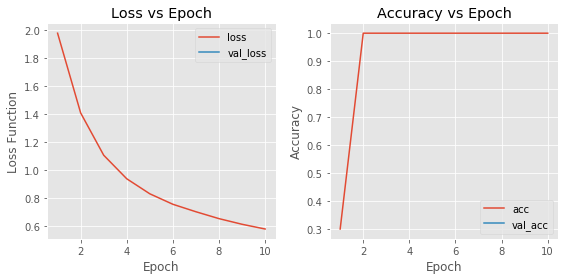

10/10 [==============================] - 1s - loss: 0.5776 - acc: 1.0000     
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_46 (Activation)   (None, 88200, 1)          0         
_________________________________________________________________
random_cropping1d_16 (Random (None, 66150, 1)          0         
_________________________________________________________________
activation_47 (Activation)   (None, 66150, 1)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 66150)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 529208    
_________________________________________________________________
activation_48 (Activation)   (None, 8)                 0         
Total params: 529,208
Trainable params: 529,208
Non-trainable pa

In [59]:


log_file_fn = 'log_trash.csv'
my_log_file_path = os.path.join(interim_trash_dir, log_file_fn)

log_fig_fn = 'log_fig.png'
my_log_fig_path = os.path.join(interim_trash_dir, log_fig_fn)


model = Sequential()

model.add(Activation(None, input_shape=(88200, 1)))
model.add(RandomCropping1D(cropping=(global_sr * 3)))#66150))

#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same',
#                        input_shape=(1, img_rows, img_cols)))

#model.add(cropping.Cropping2D(cropping=((2,2),(2,2))))
#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same'))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(img_rows/2, img_cols/2)))

model.add(Flatten())
model.add(Dense(Y_train.shape[1]))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

# fit
model.fit(X_train, Y_train,
          batch_size=5, epochs=10, verbose=1,
          callbacks=[DualPlotCallback(log_file_path=my_log_file_path, 
                                           log_fig_path=my_log_fig_path)])
model.summary()

In [60]:
DualPlotCallback?

In [21]:

model = Sequential()

model.add(Activation(None, input_shape=(88200, 1)))
model.add(RandomCropping1D(cropping=(global_sr * 3)))#66150))

#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same',
#                        input_shape=(1, img_rows, img_cols)))

#model.add(cropping.Cropping2D(cropping=((2,2),(2,2))))
#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same'))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(img_rows/2, img_cols/2)))

model.add(Flatten())
model.add(Dense(Y_train.shape[1]))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

# fit
model.fit(X_train, Y_train,
          batch_size=5, epochs=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_5 (Activation)    (None, 88200, 1)          0         
_________________________________________________________________
random_cropping1d_2 (RandomC (None, 66150, 1)          0         
_________________________________________________________________
activation_6 (Activation)    (None, 66150, 1)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 66150)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 529208    
_________________________________________________________________
activation_7 (Activation)    (None, 8)                 0         
Total params: 529,208
Trainable params: 529,208
Non-trainable params: 0
_________________________________________________________________
Epoc

# ... put RandomCropping1D in src folder

In [40]:
import numpy as np
from keras.layers import Layer
from keras.layers import InputSpec
from keras.utils import conv_utils
from keras.utils import np_utils

class RandomCropping1D(Layer):
    """Randomized cropping layer for 1D input (e.g. temporal sequence).
    It crops along the time dimension (axis 1).
    # Arguments
        cropping: int
            How many units long the cropped dimension (axis 1) will be.
            The value must be less than the original length of 
            axis 1.
    # Input shape
        3D tensor with shape `(batch, axis_to_crop, features)`
    # Output shape
        3D tensor with shape `(batch, cropped_axis, features)`
    """

    def __init__(self, cropping=None, **kwargs):
        super(RandomCropping1D, self).__init__(**kwargs)
        self.cropping = conv_utils.normalize_tuple(cropping, 1, 'cropping')
        self.input_spec = InputSpec(ndim=3)    

    def compute_output_shape(self, input_shape):
        if input_shape[1] is not None:
            length = self.cropping[0]
        else:
            length = None
        return (input_shape[0],
                length,
                input_shape[2])

    def call(self, inputs):

        if self.cropping[0] >= inputs.shape[1]:
            raise ValueError('`cropping` length should be less than the original length '
                             '(' + str(inputs.shape[1]) + ')')
        
        n_shift_max = (inputs.shape[1] + 1) - self.cropping[0]
        left = np.random.randint(0, (n_shift_max))
        right = left + self.cropping[0]
        
        return inputs[:, left:right, :]        
        
    def get_config(self):
        config = {'cropping': self.cropping}
        base_config = super(RandomCropping1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [44]:

model = Sequential()

model.add(Activation(None, input_shape=(88200, 1)))
model.add(RandomCropping1D(cropping=(global_sr * 3)))#66150))

#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same',
#                        input_shape=(1, img_rows, img_cols)))

#model.add(cropping.Cropping2D(cropping=((2,2),(2,2))))
#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same'))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(img_rows/2, img_cols/2)))

model.add(Flatten())
model.add(Dense(Y_train.shape[1]))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

# fit
model.fit(X_train, Y_train,
          batch_size=5, epochs=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_14 (Activation)   (None, 88200, 1)          0         
_________________________________________________________________
random_cropping1d_12 (Random (None, 66150, 1)          0         
_________________________________________________________________
activation_15 (Activation)   (None, 66150, 1)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 66150)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 529208    
_________________________________________________________________
activation_16 (Activation)   (None, 8)                 0         
Total params: 529,208
Trainable params: 529,208
Non-trainable params: 0
_________________________________________________________________
Epoc

In [45]:
randomcropping1d = RandomCropping1D(global_sr * 2)

print(X_train.shape)
print(randomcropping1d.call(X_train).shape)

(10, 88200, 1)
(10, 44100, 1)


In [46]:
randomcropping1d = RandomCropping1D(global_sr * 1)

for i in range(0,5):
    
    random_array = randomcropping1d.call(X_train)

    print(random_array[4,:,0].shape)

    display(Audio(data=random_array[4,:,0], rate=global_sr))

(22050,)


(22050,)


(22050,)


(22050,)


(22050,)


    random_array = randomcropping1d.call(X_train)

    for row in range(len(random_array)):

        print(random_array[row,:,0].shape)

        display(Audio(data=random_array[row,:,0], rate=global_sr))

In [362]:

model = Sequential()

model.add(Activation(None, input_shape=(88200, 1)))
model.add(RandomCropping1D(cropping=(global_sr * 2)))#66150))

#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same',
#                        input_shape=(1, img_rows, img_cols)))

#model.add(cropping.Cropping2D(cropping=((2,2),(2,2))))
#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same'))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(img_rows/2, img_cols/2)))

model.add(Flatten())
model.add(Dense(Y_train.shape[1]))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

# fit
model.fit(X_train, Y_train,
          batch_size=5, epochs=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_56 (Activation)   (None, 88200, 1)          0         
_________________________________________________________________
random_cropping1d_21 (Random (None, 44100, 1)          0         
_________________________________________________________________
activation_57 (Activation)   (None, 44100, 1)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 44100)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 352808    
_________________________________________________________________
activation_58 (Activation)   (None, 8)                 0         
Total params: 352,808
Trainable params: 352,808
Non-trainable params: 0
_________________________________________________________________
Epoc

# ...

In [193]:

model = Sequential()

model.add(Activation(None, input_shape=(88200, 1)))
model.add(RandomCropping1D(cropping=(1, 1)))

#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same',
#                        input_shape=(1, img_rows, img_cols)))

#model.add(cropping.Cropping2D(cropping=((2,2),(2,2))))
#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same'))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(img_rows/2, img_cols/2)))

model.add(Flatten())
model.add(Dense(Y_train.shape[1]))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

# fit
model.fit(X_train, Y_train,
          batch_size=5, epochs=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_35 (Activation)   (None, 88200, 1)          0         
_________________________________________________________________
random_cropping1d_8 (RandomC (None, 88198, 1)          0         
_________________________________________________________________
activation_36 (Activation)   (None, 88198, 1)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 88198)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 705592    
_________________________________________________________________
activation_37 (Activation)   (None, 8)                 0         
Total params: 705,592
Trainable params: 705,592
Non-trainable params: 0
_________________________________________________________________
Epoc

In [194]:

model = Sequential()

model.add(Activation(None, input_shape=(88200, 1)))
model.add(Cropping1D(cropping=(1, 1)))

#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same',
#                        input_shape=(1, img_rows, img_cols)))

#model.add(cropping.Cropping2D(cropping=((2,2),(2,2))))
#model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
#                        border_mode='same'))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(img_rows/2, img_cols/2)))

model.add(Flatten())
model.add(Dense(Y_train.shape[1]))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

# fit
model.fit(X_train, Y_train,
          batch_size=5, epochs=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_38 (Activation)   (None, 88200, 1)          0         
_________________________________________________________________
cropping1d_25 (Cropping1D)   (None, 88198, 1)          0         
_________________________________________________________________
activation_39 (Activation)   (None, 88198, 1)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 88198)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 705592    
_________________________________________________________________
activation_40 (Activation)   (None, 8)                 0         
Total params: 705,592
Trainable params: 705,592
Non-trainable params: 0
_________________________________________________________________
Epoc

In [44]:
with h5py.File(hdf5_path, "r") as f:
    dset = f['aud_array_dset']    
    print(dset[:50,:,0].min())
    print(dset[:50,:,:].max())    

-0.854182
0.805337


In [59]:
with h5py.File(hdf5_path, "r") as f:
    dset = f['aud_array_dset']    

    print(dset[90,:,0].shape)
    display(Audio(data=dset[300,:,0], rate=global_sr))
    
#    print(dset[:50,:,:].max())    

(88200,)


In [60]:
print(os.path.getsize(in_path), '\t', 
  os.path.getsize(out_path), '\t',
  '{:.2f}'.format(os.path.getsize(out_path) / os.path.getsize(in_path)))


NameError: name 'in_path' is not defined

In [51]:
display(Audio(data=aud_array, rate=global_sr))

In [ ]:
count = 0

for index, row in df_test.iterrows():

    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                         fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
        
    # Load the .wav audio_file
    aud_array, sr = librosa.load(audio_path, sr=global_sr)

    # Create spectrogram array
    spec_array = librosa.logamplitude(\
                    librosa.feature.melspectrogram(aud_array, 
                                                   sr=global_sr,
                                                   n_mels=global_n_mels),
                                      ref_power=1.0)[np.newaxis,:,:,
                                                     np.newaxis]
    
    # Convert spectrogram array from dtype float64 to float32
    spec_array = spec_array.astype('float32')

    # Write to the hdf5 file
    with h5py.File(test_hdf5_path, "r+") as f:
        # X_train
        dset = f['spectrogram_arrays_X_test']    
        # limit tensor height to 173 (there were a few tensors with 174)
        dset[count,:,:,:] = spec_array[:,:,:173,:]
        # y_train
        dset = f['spectrogram_arrays_y_test']    
        dset[count,:] = row['classID']

        count += 1        

# make targets fuzzy

# ...

In [4]:
file_name_in = os.listdir(fold1_path)[1:10][0]
file_name_in

'101415-3-0-2.wav'

In [5]:
in_path = os.path.join(fold1_path, file_name_in)
in_path

'../data/raw/UrbanSound8K/audio/fold1/101415-3-0-2.wav'

In [6]:
file_name_out = file_name_in.replace('.wav','.npy')
file_name_out

'101415-3-0-2.npy'

In [7]:
out_path = os.path.join(interim_trash_dir, file_name_out)
out_path

'../data/interim/trash/101415-3-0-2.npy'

In [8]:
file_name_out_hdf5 = file_name_in.replace('.wav','.hdf5')
file_name_out_hdf5

'101415-3-0-2.hdf5'

In [9]:
out_hdf5_path = os.path.join(interim_trash_dir, file_name_out_hdf5)
out_hdf5_path

'../data/interim/trash/101415-3-0-2.hdf5'

In [10]:
y, sr = librosa.load(in_path, sr=global_sr)
#y = y.astype(np.float32)

np.save(out_path,y)

print('in_size\t\t',os.path.getsize(in_path))
print('out_size\t',os.path.getsize(out_path))

in_size		 384044
out_size	 352880


In [11]:
y, sr = librosa.load(in_path, sr=global_sr)
y = y.astype(np.float32)

np.save(out_path,y)

print('in_size\t\t',os.path.getsize(in_path))
print('out_size\t',os.path.getsize(out_path))

in_size		 384044
out_size	 352880


In [12]:
y.shape

(88200,)

In [13]:
shape_tuple = y[np.newaxis,:,np.newaxis].shape
shape_tuple

(1, 88200, 1)

In [14]:
with h5py.File(out_hdf5_path, 'w') as f:
    f.create_dataset("aud_array", 
                     shape=shape_tuple, 
                     dtype='float32',
                     data=np.zeros(shape_tuple, dtype='float32'),
                     chunks=shape_tuple,
                     compression="gzip")
    

In [15]:
# Write to the hdf5 file
with h5py.File(out_hdf5_path, "r+") as f:
    # X_train
    dset = f['aud_array']    
    # limit tensor height to 173 (there were a few tensors with 174)
    dset[0,:,] = y[np.newaxis,:,np.newaxis][:,:,:] #y[:,:,:]
    # y_train
#    dset = f['aud_array']    
#    dset[count,:] = row['classID']

In [28]:
print('.wav\t',os.path.getsize(in_path), '{:.2f}'.format(os.path.getsize(in_path) / os.path.getsize(in_path)))
print('.npy\t',os.path.getsize(out_path), '{:.2f}'.format(os.path.getsize(out_path) / os.path.getsize(in_path)))
print('.hdf5\t',os.path.getsize(out_hdf5_path), '{:.2f}'.format(os.path.getsize(out_hdf5_path) / os.path.getsize(in_path)))

.wav	 384044 1.00
.npy	 352880 0.92
.hdf5	 334708 0.87


In [29]:
display(Audio(data=y, rate=global_sr))

In [36]:
wav_100 = os.listdir(fold1_path)[1:101]
len(wav_100)

100

In [ ]:
with h5py.File(out_hdf5_path, 'w') as f:
    f.create_dataset("aud_array", 
                     shape=shape_tuple, 
                     dtype='float32',
                     data=np.zeros(shape_tuple, dtype='float32'),
                     chunks=shape_tuple,
                     compression="gzip")
    

    for fn in wav_100:#[:10]:

        in_path = os.path.join(fold1_path, fn)    
        fn_out = file_name_in.replace('.wav','.npy')
        out_path =  os.path.join(interim_trash_dir, fn_out)

        y, _ = librosa.load(in_path, sr=global_sr)    
        y = y.astype(np.float32)
        np.save(out_path, y)

    #    print(in_path)
        if len(y) == 88200:
            print(os.path.getsize(in_path), '\t', 
                  os.path.getsize(out_path), '\t',
                  '{:.2f}'.format(os.path.getsize(out_path) / os.path.getsize(in_path)))
        else:
            print('length: {:.2f} seconds'.format(len(y) / global_sr))